## Synaptic Conductance Model
You will have the above 3 neurons synapse onto a synaptic conductance model (as described in section 5.8 of Dayan and Abbott). This model is simply a Hodgkin-Huxley Model with a synaptic conductance term added (and no external current injection providing excitation). Do not try to account for short term plasticity; keep it simple.
Develop a spike counter to reliably detect how many times this cell spikes during the 300 ms time window.
Aim to have this neuron spike somewhere between 10 and 40 Hz when contrast is .5. This is tuned by changing the conductance parameter for the synaptic connection. 
Keep in mind that the above firing rate model doesn't have to be finished to tune the synaptic conductance model.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Calculate activation/inactivation rates for Na+ and K+ currents
def activationOnRate(V):
    #alpha_m
    c1 = 0.1
    c2 = -0.1
    return c1*(V+40)/(1 - np.exp(c2*(V+40)))

def activationOffRate(V):
    #beta_m
    c1 = 4
    c2 = -0.0556
    return c1*np.exp(c2*(V+65))

def inactivationOnRate(V):
    #alpha_h
    c1 = 0.07
    c2 = -0.05
    return c1*np.exp(c2*(V+65))

def inactivationOffRate(V):
    #beta_h
    c1 = 1
    c2 = -0.1
    return c1/(1 + np.exp(c2*(V+35)))

def openRate(V):
    #alpha_n
    c1 = 0.01
    c2 = -0.1
    return c1*(V+55)/(1 - np.exp(c2*(V+55)))

def closedRate(V):
    #beta_n
    c1 = 0.125
    c2 = -0.0125
    return c1*np.exp(c2*(V+65))

# Other functions for activation/inactivation variables
def tau_var(alpha_var, beta_var):
    return 1/(alpha_var + beta_var)

def var_inf(alpha_var, beta_var):
    return alpha_var/(alpha_var + beta_var)

In [3]:
def simulateHHNeuron(len_sim, presynaptic_spike_train, gs, gK, dt=0.1):
    #Hodgkin Huxley Neuron Parameters
    V_rest = -70 #mV
    R_m = 10 #m ohms
    tau_mem = 10 #ms

    V_thr = -54 #mV
    V_reset = -80 #mV

    c_m = 10 #nF/mm2

    #Channel Constants
    E_Na = 50 #mV
    g_Na = 1.2e3 #mS/mm2

    E_K = -77 #mV
    g_K = gK*1e3 #mS/mm2

    E_L = -54.387 #mV
    g_L = 0.003e3 #mS/mm2

    #Time stuff
    sim_time = int(len_sim/dt)

    #Initialize variables
    V = np.zeros(sim_time)
    V[0] = -65 #mV

    m = np.zeros(sim_time)
    m[0] = 0.0529

    h = np.zeros(sim_time)
    h[0] = 0.5961

    n = np.zeros(sim_time)
    n[0] = 0.3177

    spike_count = 0

    #Synaptic Conductance Params
    P_max = 0.5
    tau_s = 10 #ms

    #Initialize Synaptic Conductance values
    z = 0
    P_s = np.zeros(sim_time)
    
    #Run Simulation
    for t in range(sim_time)[1:]:
        #Sodium Current Variables
        # activation component
        alpha_m = activationOnRate(V[t-1])
        beta_m = activationOffRate(V[t-1])
        tau_m  = tau_var(alpha_m, beta_m)
        m_inf = var_inf(alpha_m, beta_m)

        # integration method from appendix A yields
        m[t] = m_inf + (m[t-1] - m_inf)*np.exp(-dt/tau_m)

        # inactivation component
        alpha_h = inactivationOnRate(V[t-1])
        beta_h = inactivationOffRate(V[t-1])
        tau_h  = tau_var(alpha_h, beta_h)
        h_inf = var_inf(alpha_h, beta_h)

        h[t] = h_inf + (h[t-1] - h_inf)*np.exp(-dt/tau_h)

        #Potassium Current Variables
        alpha_n = openRate(V[t-1])
        beta_n = closedRate(V[t-1])
        tau_n = tau_var(alpha_n, beta_n)
        n_inf = var_inf(alpha_n, beta_n)

        n[t] = n_inf + (n[t-1] - n_inf)*np.exp(-dt/tau_n)

        #Synpatic Conductance Variables
        #Calculate z
        dz = -z / (tau_s/dt)
        z += dz
        if presynaptic_spike_train[t] > 0:
            z = presynaptic_spike_train[t]

        #Calculate P_s
        dP_s = (np.exp(1)*P_max*z-P_s[t-1]) / (tau_s/dt)
        P_s[t] = P_s[t-1] + dP_s

        #Calc membrane potential
        # sum conductances
        g_all = g_L + g_K*n[t]**4 + g_Na*m[t]**3*h[t] + gs*P_s[t]

        # numerical differentiation of dV/dt
        tau_V = c_m/g_all
        V_inf = (g_L*E_L + g_K*n[t]**4*E_K + g_Na*m[t]**3*h[t]*E_Na + gs*P_s[t])/g_all
        V[t] = V_inf + (V[t-1] - V_inf)*np.exp(-dt/tau_V)
        
        #Count number of spikes
        if V[t-1] <=20 and V[t] > 20:
            spike_count+=1
            
    return P_s, V, spike_count

In [4]:
conditions = range(8)
trials = range(30)

all_spikes = np.load('part_1_spike_outputs.npy')
spike_counts = np.zeros((8, 30))
tea_spike_counts = np.zeros((8, 30))
pre_spikes = np.zeros((8, 30))

for condition in conditions:
    for trial in trials:
        fr_model_spikes = all_spikes[condition, :, trial, :]
        fr_spike_sum = np.sum(fr_model_spikes, 0)
        pre_spikes[condition, trial] = np.sum(fr_spike_sum)
        # Simulate HH Neuron with summed input from presynaptic neurons
        spike_count = simulateHHNeuron(300, fr_spike_sum, 1.3, 0.36, 0.1)[2]
        spike_counts[condition, trial] = spike_count
        # Reduce g_K from default 0.36 to 0.045 to increase AP duration
        tea_spike_count = simulateHHNeuron(300, fr_spike_sum, 1.3, 0.045, 0.1)[2]
        tea_spike_counts[condition, trial] = tea_spike_count
        

Response Rate: 60.0 Hz
TEA Response Rate: 96.66666666666667 Hz


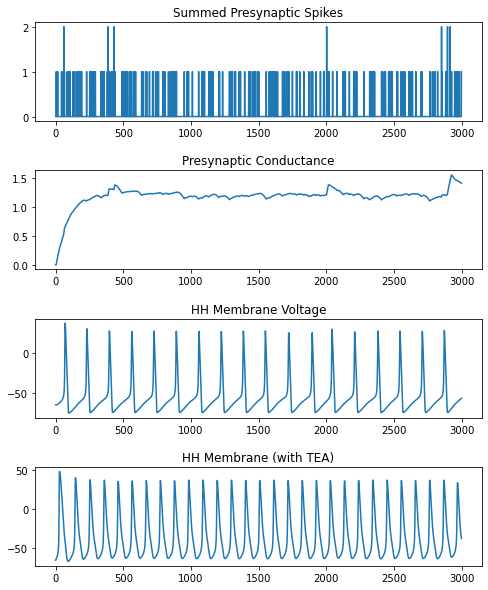

In [5]:
#TEST: Contrast = 0.5, Trial #1

fr_model_spikes = all_spikes[4, :, 1, :]
fr_spike_sum = np.sum(fr_model_spikes, 0)
ps, v, sc = simulateHHNeuron(300, fr_spike_sum, 1.3, 0.36, 0.1)
psT, vT, scT = simulateHHNeuron(300, fr_spike_sum, 1.3, 0.045, 0.1)


print("Response Rate: " + str(sc/0.3)+" Hz")
print("TEA Response Rate: " + str(scT/0.3)+" Hz")

plt.figure(figsize=(8, 10))

plt.subplot(4, 1, 1)
plt.plot(fr_spike_sum)
plt.title('Summed Presynaptic Spikes')
plt.subplot(4, 1, 2)
plt.plot(ps)
plt.title('Presynaptic Conductance')
plt.subplot(4, 1, 3)
plt.plot(v)
plt.title('HH Membrane Voltage')
plt.subplot(4, 1, 4)
plt.plot(vT)
plt.title('HH Membrane (with TEA)')

plt.subplots_adjust(hspace=0.5)


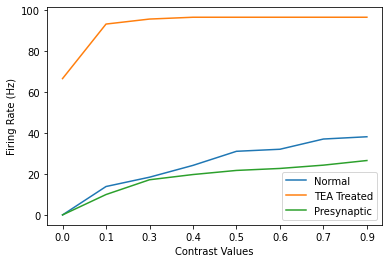

In [6]:
contrast_values = [0.0, 0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]

avg_spike_count = np.mean(spike_counts, 1)
avg_tea_spike_count = np.mean(tea_spike_counts, 1)
avg_presyn_spike = np.mean(pre_spikes, 1)
plt.plot(conditions, avg_spike_count/0.3)
plt.plot(conditions, avg_tea_spike_count/0.3)
plt.plot(avg_presyn_spike/3*0.3)

plt.xticks(conditions, contrast_values)
plt.xlabel('Contrast Values')
plt.ylabel('Firing Rate (Hz)')
plt.legend(['Normal', 'TEA Treated', 'Presynaptic'])

In [7]:
# spike_counts.tofile('synConductanceSpikeCounts.csv', sep = ',')
# tea_spike_counts.tofile('synConductanceSpikeCountsTEA.csv', sep = ',')

In [8]:
np.save("spikes.npy", spike_counts, allow_pickle=True, fix_imports=True)
np.save("spikes_TEA.npy", tea_spike_counts, allow_pickle=True, fix_imports=True)

In [9]:
with open('spikes.npy', 'rb') as f:

    b = np.load(f)

print(b)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 6.  4.  5.  6.  2.  3.  3.  3.  7.  3.  4.  3.  9.  6.  6.  7.  2.  3.
   4.  5.  1.  3.  4.  1.  2.  3.  1. 11.  2.  6.]
 [ 6.  4.  8.  5.  4.  6.  4.  3.  4.  7. 12.  3.  7.  7.  5.  9.  1.  4.
   4.  2. 10.  4.  6.  4.  4. 15.  6.  3.  5.  4.]
 [ 5. 17. 12.  6.  7.  4.  6.  2. 11. 13.  3.  4.  5.  3.  6.  2.  7.  1.
   5. 11. 11. 10. 13.  3.  5.  8.  9.  9. 12.  8.]
 [10. 18.  9. 14.  4. 17.  7.  3.  6. 13. 11. 10.  6. 17.  4.  5. 18. 14.
   5. 10.  4.  7.  2.  6. 18. 14.  7. 10.  9.  2.]
 [ 9. 11.  8. 13. 18.  3.  6. 19.  6.  5.  6. 13.  5. 18. 13.  6.  5. 11.
  17. 14. 11. 18.  4.  4.  5. 10.  6.  6.  8. 11.]
 [ 4. 13.  5.  3. 11. 18.  7. 11. 13. 17. 12. 18. 18. 14.  4. 18.  5.  2.
  10. 17.  3. 18. 11. 12. 11.  4. 11. 18.  8. 18.]
 [ 2. 17. 18. 12.  3. 10. 12. 17. 19.  9.  6. 18.  4. 19. 18.  9. 19. 11.
   4.  7. 13. 15.  3. 19. 12.  8.  3. 18.  5. 14.]]